## Identify the "start of climate change" 
The algorithm is as follows, applied to a variable (Y):

1. Identify inflection (T0) point as "start of climate change": point where dY/dt != 0 for remainder of record
2. Compute trend (ω) from that point forward
3. Compute ToE as a timescale: ToE = 2 σ / ω
4. Year of detection = T0 + ToE

In [1]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')


In [2]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf[variables].sel(length = 40).sel(region = 'Southern Ocean')
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
    length     float64 40.0
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    region     <U17 'Southern Ocean'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [3]:
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_ref_mean

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    length    float64 40.0
    region    <U17 'Southern Ocean'
Data variables:
    SST       float64 4.782
    Chl_surf  float64 0.7665
    KGP       float64 0.009773

Standard deviation of anomalies

In [4]:
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
ds_ref_std

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    length    float64 40.0
    region    <U17 'Southern Ocean'
Data variables:
    SST       float64 0.1896
    Chl_surf  float64 0.04342
    KGP       float64 0.00237

### calculate and plot the anomalies relative to the reference

In [5]:
forced = ds_djf.mean('member_id')     
anom_f = forced - ds_ref_mean
anom_f

<xarray.Dataset>
Dimensions:   (time: 180)
Coordinates:
    length    float64 40.0
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
    region    <U17 'Southern Ocean'
Data variables:
    SST       (time) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    Chl_surf  (time) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    KGP       (time) float64 dask.array<chunksize=(90,), meta=np.ndarray>

Text(0.5, 1.0, 'Daily growth rate anomaly ')

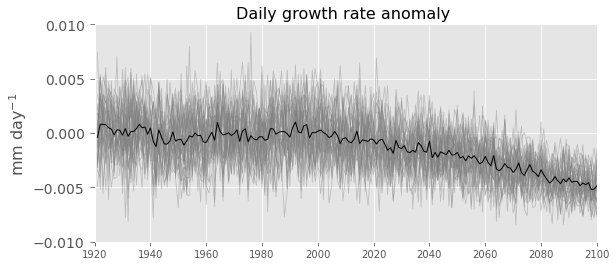

In [11]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)

## Calculate cumulative integrals

In [12]:
x = anom_f['time'] # The coordinate to integrate along.

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y_k = anom_f['KGP'].values # Values to integrate.
y_int_k = xr.full_like(anom_f['KGP'], fill_value=0)
y_int_k.values = integrate.cumtrapz(y_k, x, initial=0)

y_t = anom_f['SST'].values # Values to integrate.
y_int_t = xr.full_like(anom_f['SST'], fill_value=0)
y_int_t.values = integrate.cumtrapz(y_t, x, initial=0)

y_c = anom_f['Chl_surf'].values # Values to integrate.
y_int_c = xr.full_like(anom_f['Chl_surf'], fill_value=0)
y_int_c.values = integrate.cumtrapz(y_c, x, initial=0)

#### plot to see

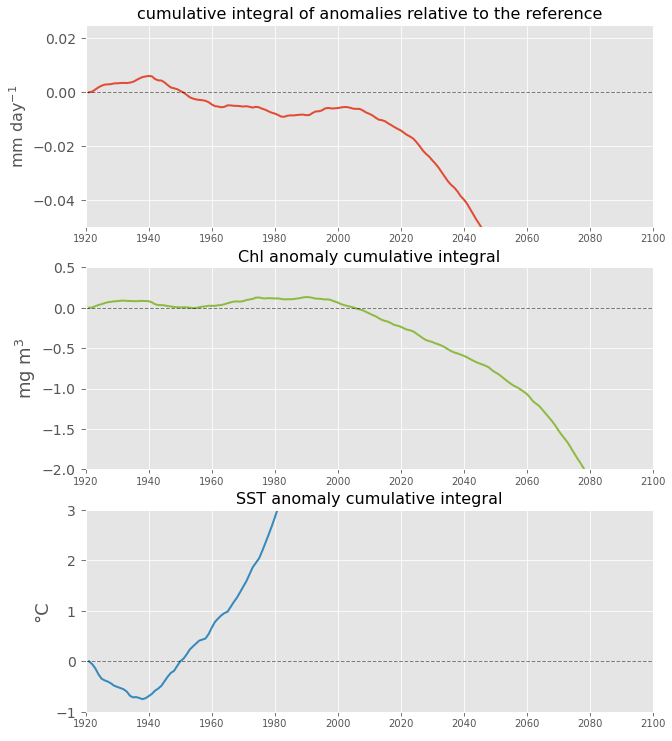

In [13]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-.05, .025])
ax.plot(x, y_int_k, linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#ax.plot(1920+thresh_k, 0, 'r*', markersize=15, color = 'C0')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)
ax.set_ylim([-1, 3])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.plot(x, y_int_t, color='C1', linewidth = 2)
#ax.plot(1920+thresh_t, 0, 'r*', markersize=15, color='C1')
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('SST anomaly cumulative integral', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-2, .5])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.plot(x, y_int_c, color='C5', linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#ax.plot(1920+thresh_c, 0, 'r*', markersize=15, color='C5')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('Chl anomaly cumulative integral', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92, right =1)

# title = ('cumulative integrals dark')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + file, bbox_inches='tight')

### ID Inflection Point

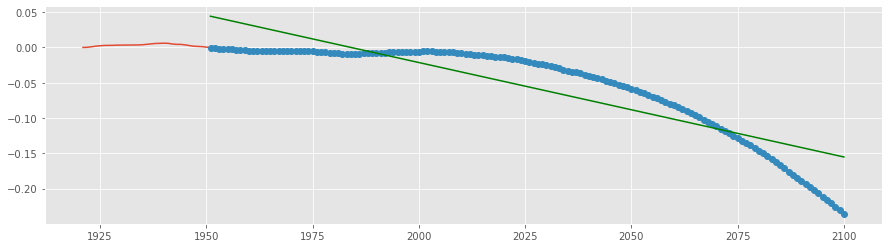

In [14]:
#Here's a little mock up of trend post inflection point
x = anom_f['time'] # The coordinate to integrate along.
y = y_int_k

for l in range(len(x)):
    if all(y[l:] < 0):
        ndx = l
        break

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x[ndx:], y[ndx:], 'o')
beta = np.polyfit(x[ndx:], y[ndx:], 1)
plt.plot(x[ndx:], beta[1] + beta[0]*x[ndx:], 'g-')

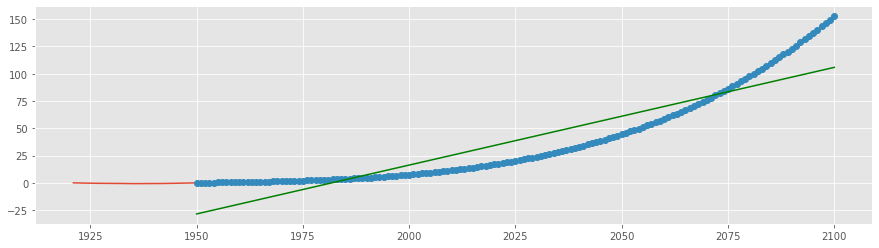

In [29]:
#Here's a little mock up of trend post inflection point
x = anom_f['time'] # The coordinate to integrate along.
y = y_int_t

for l in range(len(x)):
    if all(y[l:] > 0):
        ndx = l
        break

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x[ndx:], y[ndx:], 'o')
beta = np.polyfit(x[ndx:], y[ndx:], 1)
plt.plot(x[ndx:], beta[1] + beta[0]*x[ndx:], 'g-')

In [37]:
# Isolate the climate change signal
x = anom_f['time'] # The coordinate to integrate along.
for l in range(len(x)): # krill
    if all(y_int_k[l:] < 0):
        ndx_k = l
        break
#krill        
x_cc_k = x[ndx_k:]
y_cc_k = y_int_k[ndx_k:]
beta_k = np.polyfit(x_cc_k, y_cc_k, 1)
bf_k = beta_k[1] + beta_k[0]*x_cc_k
        
for l in range(len(x)): # chlorophyll
    if all(y_int_c[l:] < 0):
        ndx_c = l
        break

#chlorophyll        
x_cc_c = x[ndx_c:]
y_cc_c = y_int_c[ndx_c:]
beta_c = np.polyfit(x_cc_c, y_cc_c, 1)
bf_c = beta_c[1] + beta_c[0]*x_cc_c

for l in range(len(x)): # temp
    if all(y_int_t[l:] > 0):
        ndx_t = l    
        break
#sst        
x_cc_t = x[ndx_t:]
y_cc_t = y_int_t[ndx_t:]
beta_t = np.polyfit(x_cc_t, y_cc_t, 1)
bf_t = beta_t[1] + beta_t[0]*x_cc_t

# #TEST
# plt.figure(figsize=(15, 4))
# plt.plot(x, y_int_k)
# plt.plot(x_cc_k, y_cc_k, 'o')
# plt.plot(x_cc_k, bf_k, 'g-')

In [44]:
plt.style

<module 'matplotlib.style' from '/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/matplotlib/style/__init__.py'>

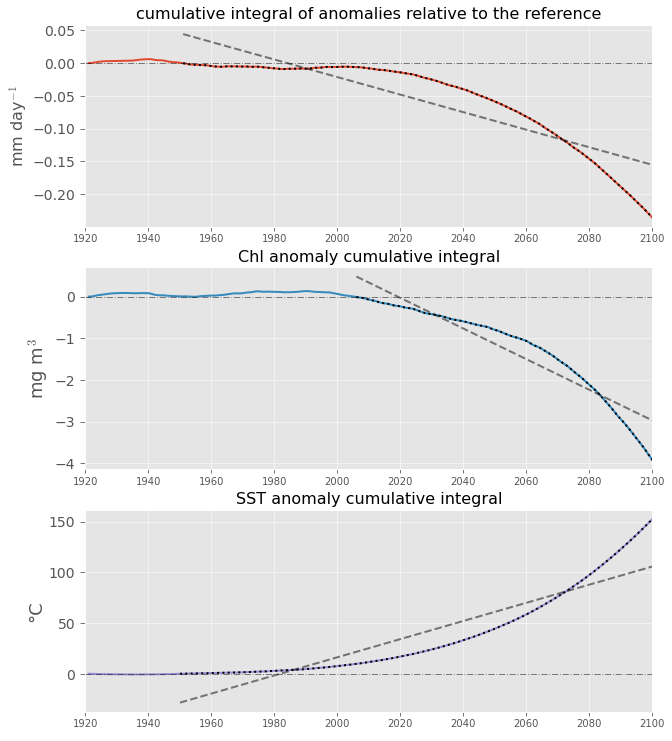

In [48]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-.05, .025])
ax.plot(x, y_int_k, color = 'C0', linewidth = 2) # full time series
ax.plot(x_cc_k, y_cc_k, color = 'k', linestyle=':') # post climate change
ax.plot(x_cc_k, bf_k, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);
#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-2, .5])
ax.plot(x, y_int_c, color = 'C1', linewidth = 2) # full time series
ax.plot(x_cc_c, y_cc_c, color = 'k', linestyle=':') # post climate change
ax.plot(x_cc_c, bf_c, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('Chl anomaly cumulative integral', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)
#ax.set_ylim([-1, 3])
ax.plot(x, y_int_t, color = 'C2', linewidth = 2)
ax.plot(x_cc_t, y_cc_t, color = 'k', linestyle=':')
ax.plot(x_cc_t, bf_t, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('SST anomaly cumulative integral', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92, right =1)

title = ('cumulative integrals ')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

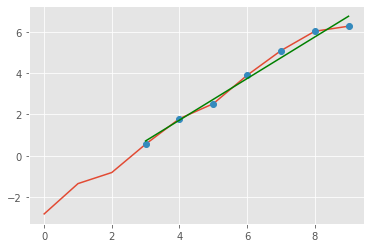

In [28]:
# #Here's a little mock up of trend post inflection point
# x = np.arange(0, 10, 1)
# y = -3 + x*1.02 + np.random.rand(10)

# for l in range(len(x)):
#     if all(y[l:] > 0):
#         ndx = l
#         break

# plt.plot(x, y)
# plt.plot(x[ndx:], y[ndx:], 'o')

# beta = np.polyfit(x[ndx:], y[ndx:], 1)
# plt.plot(x[ndx:], beta[1] + beta[0]*x[ndx:], 'g-')